# Kickoff Capstone Insper DAO 2024

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.csv', na_values="-")
df = df.rename(columns = {"px_close": "Price"})
df = df[df["Active"] == "PETR4<XBSP>"]
df = df.set_index("Date").drop(columns="Active").reset_index()
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Date"] > "2018"]
df['Price'] = df['Price'].ffill()
df

,Date,Price
8348,2018-01-02,16.55
8349,2018-01-03,16.70
8350,2018-01-04,16.73
8351,2018-01-05,16.83
8352,2018-01-08,17.03
...,...,...
9997,2024-04-29,42.15
9998,2024-04-30,42.02
9999,2024-05-01,42.02
10000,2024-05-02,42.18


## 1. Cálculo do Retorno Diário
Primeiro, vamos calcular o retorno diário.

In [12]:
# Supondo que df é seu DataFrame com as colunas 'Date' e 'Price'
df['Return'] = df['Price'].pct_change()

# Remover o primeiro valor NA criado pela mudança percentual
df.dropna(inplace=True)

# Exibir os primeiros 5 retornos
df[['Date', 'Price', 'Return']].head()

,Date,Price,Return
8349,2018-01-03,16.70,0.009063
8350,2018-01-04,16.73,0.001796
8351,2018-01-05,16.83,0.005977
8352,2018-01-08,17.03,0.011884
8353,2018-01-09,17.03,0.000000


## 2. Cálculo da Volatilidade (Desvio Padrão dos Retornos)
Agora, vamos calcular a volatilidade, que é o desvio padrão dos retornos.

In [13]:
# Volatilidade anualizada
volatility = df['Return'].std() * (252 ** 0.5)  # 252 dias úteis no ano

print(f"Volatilidade anualizada: {volatility:.4f}")

Volatilidade anualizada: 0.4577


## 3. Cálculo do Sharpe Ratio
Vamos calcular o Sharpe Ratio. Supondo que a taxa livre de risco anual seja 3% (ou seja, 0.03).

In [14]:
# Taxa livre de risco diária
risk_free_rate = 0.03 / 252

# Retorno médio diário
average_return = df['Return'].mean()

# Sharpe Ratio anualizado
sharpe_ratio = (average_return - risk_free_rate) / volatility

print(f"Sharpe Ratio anualizado: {sharpe_ratio:.4f}")

Sharpe Ratio anualizado: 0.0018


## 4. Backtesting Simples de uma Estratégia de Média Móvel
Aqui, vamos implementar uma estratégia simples de média móvel: comprar papel quando o preço estiver acima da média móvel de 50 dias e vender quando estiver abaixo.

In [27]:
# Calcular a média móvel de 50 dias
df['MA50'] = df['Price'].rolling(window=50).mean()

# Criar uma coluna de sinal: 1 (compra) se o preço estiver acima da MA50, -1 (venda) se estiver abaixo
df['Signal'] = 0
df.loc[df['Price'] > df['MA50'], 'Signal'] = 1
df.loc[df['Price'] < df['MA50'], 'Signal'] = -1

# Calcular o retorno da estratégia (retorno da posição diária multiplicado pelo sinal do dia anterior)
df['Strategy_Return'] = df['Signal'].shift(1) * df['Return']

# Calcular o retorno acumulado da estratégia
df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod()

# Calcular o retorno acumulado do buy and hold
df['Cumulative_Return'] = (1 + df['Return']).cumprod()

# Exibir os primeiros 5 resultados
df[['Date', 'Price', 'MA50', 'Signal','Strategy_Return','Cumulative_Strategy_Return', 'Cumulative_Return']].tail()


,Date,Price,MA50,Signal,Strategy_Return,Cumulative_Strategy_Return,Cumulative_Return
9997,2024-04-29,42.15,39.0728,1,0.017870,0.209227,2.546828
9998,2024-04-30,42.02,39.0642,1,-0.003084,0.208582,2.538973
9999,2024-05-01,42.02,39.0544,1,0.000000,0.208582,2.538973
10000,2024-05-02,42.18,39.0542,1,0.003808,0.209376,2.548640
10001,2024-05-03,39.89,39.0140,1,-0.054291,0.198009,2.410272


## 5. Visualizando os Resultados
Vamos plotar os retornos acumulados da estratégia versus a estratégia de "buy and hold".

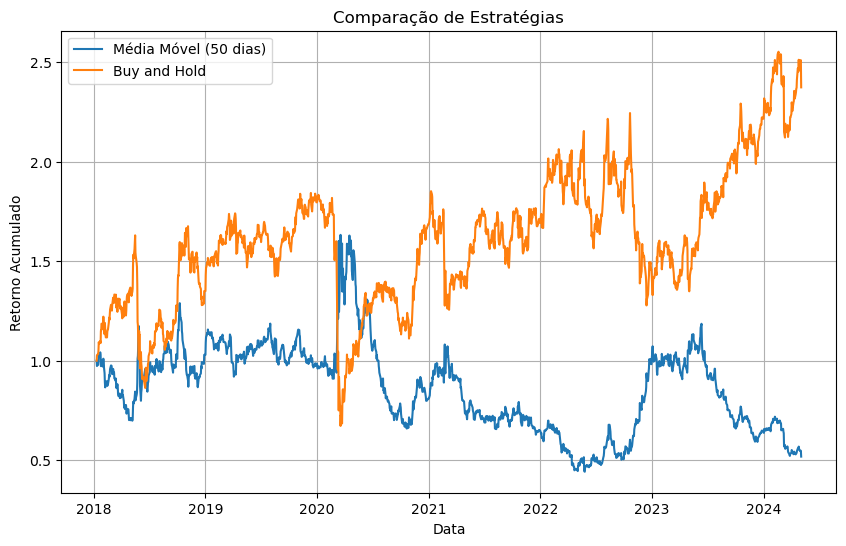

In [25]:

plot_df = df.copy().iloc[50:]
plot_df.loc[:, 'Cumulative_Strategy_Return'] = plot_df['Cumulative_Strategy_Return'].div(plot_df['Cumulative_Strategy_Return'].iloc[0])
plot_df.loc[:, 'Cumulative_Return'] = plot_df['Cumulative_Return'].div(plot_df['Cumulative_Return'].iloc[0])


plt.figure(figsize=(10, 6))
plt.plot(plot_df['Date'], plot_df['Cumulative_Strategy_Return'], label='Média Móvel (50 dias)')
plt.plot(plot_df['Date'], plot_df['Cumulative_Return'], label='Buy and Hold')
plt.title('Comparação de Estratégias')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid()
plt.show()

## 6. Interpretação dos Resultados
#### Retorno: O retorno diário nos dá uma ideia da variação percentual do preço de um dia para o outro.

#### Volatilidade: A volatilidade anualizada nos informa o risco associado ao papel durante o período analisado.

#### Sharpe Ratio: O Sharpe Ratio ajusta o retorno pelo risco, mostrando a qualidade do retorno em relação à volatilidade.

#### Backtest: A estratégia de média móvel simples foi testada contra o "buy and hold", permitindo comparar se a estratégia traz algum valor adicional.